In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import cupy as cp

In [4]:
import numpy as np
import pandas as pd
import tensorflow_text
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import clustering
from sentence_transformers import SentenceTransformer
from collections import Counter
from hyperopt import hp
import random
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adilbek.karmanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/adilbek.karmanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Reading tweet files

In [5]:
folder = 'files/'
df_with_sw = pd.read_csv(folder + 'clean_tweets_with_stopwords.csv')
df_without_sw = pd.read_csv(folder + 'clean_tweets_without_stopwords.csv')

In [6]:
#Extract tweet data
tweets_with_sw = df_with_sw['tweet']
tweets_without_sw = df_without_sw['tweet']

### Getting encodings using Bag of Words

In [7]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
embeddings_bow = cp.asarray(bow_vectorizer.fit_transform(tweets_without_sw).toarray())

### Getting encodings using TF-IDF

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
embeddings_tfidf = cp.asarray(tfidf_vectorizer.fit_transform(tweets_without_sw).toarray())

### Getting encodings using Word2Vec

In [10]:
embeddings_wordvec = cp.asarray(clustering.word2vec(tweets_without_sw))

### Getting encodings using different Transformer Encoder models

In [11]:
model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
model_mpnet = SentenceTransformer('all-mpnet-base-v2', device="cpu")
model_minilm = SentenceTransformer('all-MiniLM-L6-v2', device="cpu")
model_distil = SentenceTransformer('all-distilroberta-v1', device="cpu")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
2021-12-03 23:34:34.153110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/local/VSCode-linux-x64
2021-12-03 23:34:34.153177: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-03 23:34:34.153457: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other op

In [12]:
embeddings_use = cp.asarray(model_use(tweets_with_sw))
embeddings_mpnet = cp.asarray(model_mpnet.encode(tweets_with_sw, show_progress_bar=True))
embeddings_minilm = cp.asarray(model_minilm.encode(tweets_with_sw, show_progress_bar=True))
embeddings_distil = cp.asarray(model_distil.encode(tweets_with_sw, show_progress_bar = True))

Batches: 100%|██████████| 382/382 [01:31<00:00,  4.17it/s]


### UMAP + HDBSCAN with different encoding techniques

#### Bag of Words:

In [39]:
clusters_bow, score_bow = clustering.generate_clusters(embeddings_bow,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=50,
                                                    min_cluster_size=120
                                                    )

Label prop iterations: 21
Label prop iterations: 9
Label prop iterations: 4
Iterations: 3
17807,19403,10438,13,6932,96541


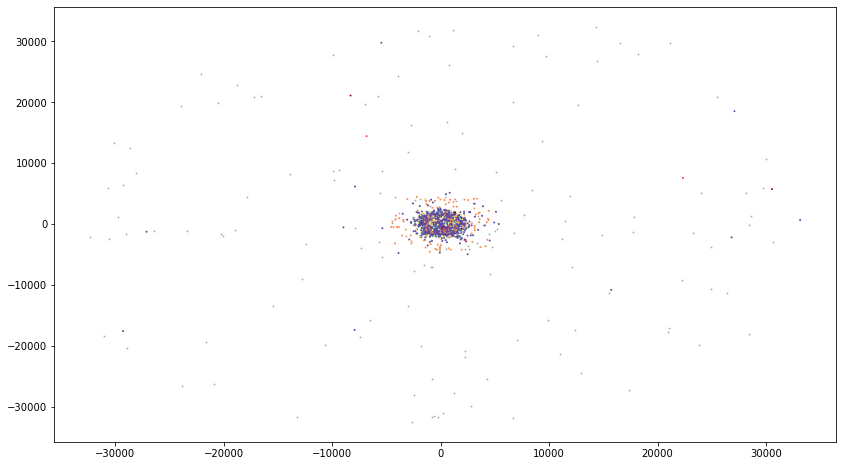

In [41]:
clustering.plot_clusters(embeddings_bow, clusters_bow, n_neighbors=150, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_without_sw, clusters_bow.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,1764,"[haha, yes, amp, welcome, youre, yup, absolute...","[120, 69, 61, 51, 42, 42, 39, 38, 38, 37]"
1,0,126,"[ok, glad, youre, haha, engines, fine, 3owners...","[110, 13, 10, 3, 3, 3, 3, 3, 2, 2]"
2,1,165,"[coming, soon, point, good, tesla, amp, one, l...","[94, 91, 52, 49, 17, 8, 6, 5, 5, 5]"
3,2,434,"[yes, amp, 1, lot, 7, good, 3, much, 13031925,...","[432, 14, 9, 8, 8, 8, 7, 7, 7, 7]"
4,3,196,"[true, haha, actually, amp, still, tesla, many...","[189, 31, 15, 10, 6, 6, 5, 5, 4, 4]"
5,4,183,"[sure, make, amp, hope, 1, way, need, yes, 45,...","[179, 15, 11, 9, 7, 7, 7, 6, 5, 5]"
6,5,147,"[exactly, good, 1, amp, many, actually, thats,...","[147, 6, 6, 5, 5, 5, 5, 5, 4, 4]"
7,6,144,"[cool, course, would, interesting, love, still...","[84, 46, 15, 10, 9, 8, 8, 6, 6, 6]"
8,7,149,"[yeah, like, hard, make, amp, would, thats, im...","[149, 8, 8, 7, 7, 6, 6, 5, 5, 5]"
9,8,8616,"[amp, tesla, good, model, like, great, 3, woul...","[1785, 981, 403, 390, 371, 360, 343, 312, 308,..."


In [42]:
score_bow

-0.35099569609942727

#### TF-IDF:

In [43]:
clusters_tfidf, score_tfidf = clustering.generate_clusters(embeddings_tfidf,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=50,
                                                    min_cluster_size=200
                                                    )

Label prop iterations: 20
Label prop iterations: 6
Label prop iterations: 5
Iterations: 3
18500,19784,12058,13,7634,95118


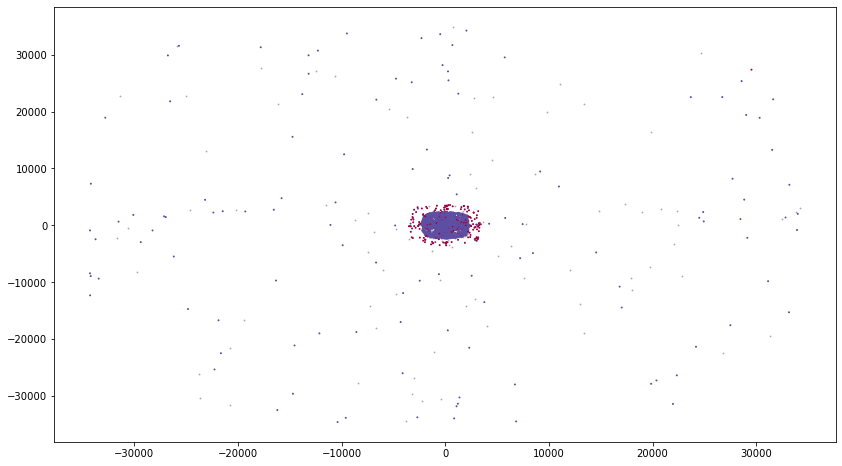

In [ ]:
clustering.plot_clusters(embeddings_tfidf, clusters_tfidf, n_neighbors=200, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_without_sw, clusters_tfidf.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,1104,"[amp, tesla, car, 3, would, model, high, time,...","[265, 135, 55, 54, 51, 51, 43, 41, 41, 39]"
1,0,311,"[yes, 7, 1, 8, um, 3, done, 2908, 5, 6]","[295, 7, 5, 4, 3, 3, 3, 2, 2, 2]"
2,1,10509,"[amp, tesla, good, like, great, model, would, ...","[1641, 916, 447, 372, 368, 353, 329, 321, 286,..."


In [44]:
score_tfidf

-0.30085204055757725

#### Word2vec:

In [45]:
clusters_wordvec, score_wordvec = clustering.generate_clusters(embeddings_wordvec,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=70,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 24
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 3
Iterations: 4
18804,19451,9598,15,7135,97278


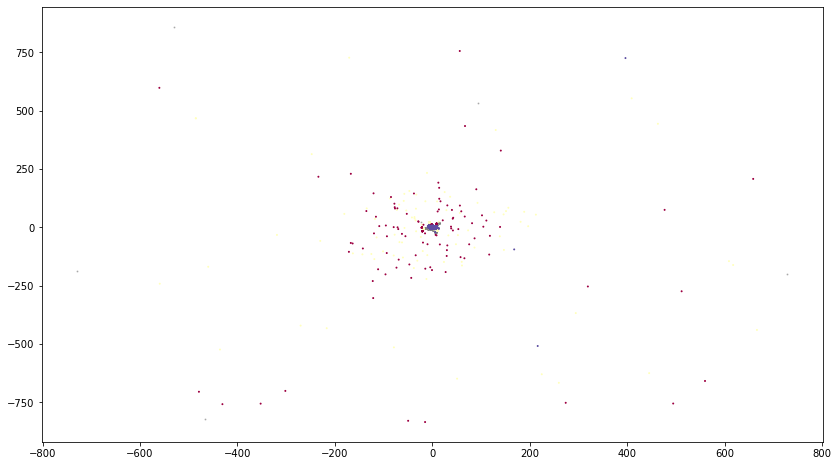

In [ ]:
clustering.plot_clusters(embeddings_wordvec, clusters_wordvec, n_neighbors = 50, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_without_sw, clusters_wordvec.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,274,"[true, sure, thanks, much, yup, pretty, absolu...","[49, 45, 34, 29, 28, 22, 19, 17, 17, 9]"
1,0,337,"[yes, exactly, yeah, 3201, 1stprinciples4l, 7x...","[238, 68, 31, 1, 1, 1, 1, 1, 1, 1]"
2,1,319,"[ok, haha, sure, touché, yup, hg2g, samwise, n...","[52, 44, 18, 3, 3, 2, 2, 2, 2, 2]"
3,2,10994,"[amp, tesla, good, like, model, great, would, ...","[1908, 1053, 488, 405, 404, 390, 381, 378, 330..."


In [46]:
score_wordvec

-0.10204440022874306

#### USE:

In [47]:
clusters_use, score_use = clustering.generate_clusters(embeddings_use,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=90,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 22
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
18496,23495,11786,13,9179,97197


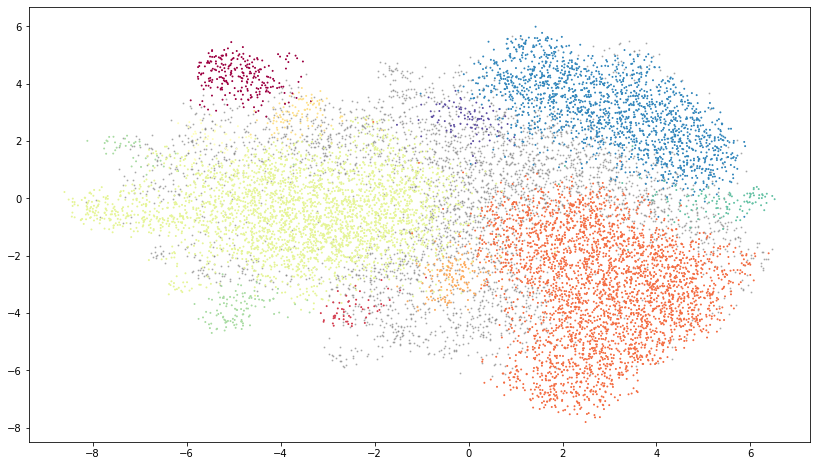

In [ ]:
clustering.plot_clusters(embeddings_use, clusters_use, n_neighbors=30, min_dist=1.0)

In [ ]:
tweets_without_sw.shape

(11924,)

In [ ]:
clustering.top_ten_words(tweets_with_sw, clusters_use.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,3477,"[amp, erdayastronaut, good, model, tesla, like...","[452, 146, 146, 129, 123, 111, 109, 106, 103, ..."
1,0,243,"[nichegamer, ppathole, theonion, rationaletien...","[10, 7, 7, 6, 4, 4, 4, 4, 4, 3]"
2,1,54,"[twitter, tweets, mkbhd, tweet, reddit, real, ...","[31, 8, 7, 7, 7, 3, 3, 3, 3, 2]"
3,2,3097,"[tesla, amp, model, car, cars, production, goo...","[1691, 984, 331, 273, 195, 171, 148, 132, 132,..."
4,3,149,"[amp, media, people, public, like, know, would...","[40, 26, 18, 16, 10, 10, 10, 8, 8, 8]"
5,4,96,"[flcnhvy, teslaownerssv, grimezsz, kristennett...","[9, 6, 5, 5, 5, 5, 4, 3, 3, 3]"
6,5,52,"[haha, ahem, lol, evafoxu, lexfridman, trouble...","[30, 4, 4, 3, 2, 2, 2, 2, 1, 1]"
7,6,3016,"[yes, flcnhvy, great, erdayastronaut, exactly,...","[308, 122, 107, 92, 89, 88, 78, 76, 76, 70]"
8,7,145,"[true, sure, haha, flcnhvy, teslaownerssv, cle...","[96, 30, 15, 13, 6, 6, 4, 4, 4, 3]"
9,8,108,"[tunnel, boring, tunnels, amp, la, company, fi...","[60, 32, 29, 19, 19, 16, 14, 10, 10, 9]"


In [48]:
score_use

-0.08745322549127307

#### MPNET

In [49]:
clusters_mpnet, score_mpnet = clustering.generate_clusters(embeddings_mpnet,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=90,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 24
Label prop iterations: 4
Label prop iterations: 3
Label prop iterations: 3
Iterations: 4
19442,21290,10616,19,10654,102511


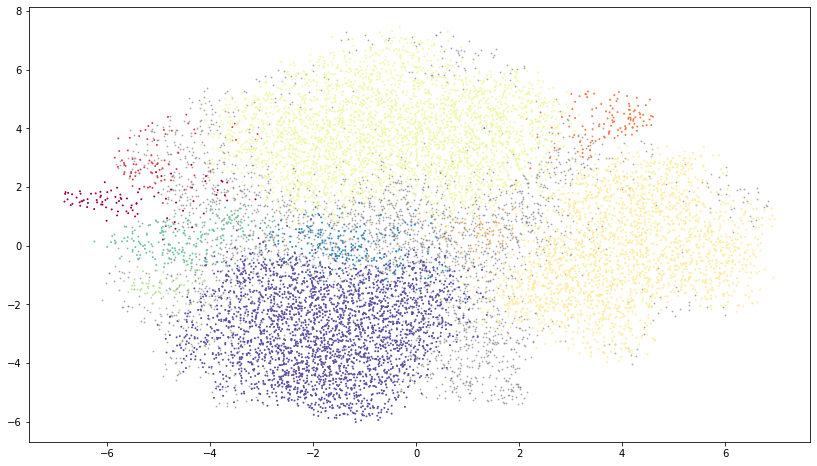

In [ ]:
clustering.plot_clusters(embeddings_mpnet, clusters_mpnet, n_neighbors=30, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_with_sw, clusters_mpnet.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,3147,"[amp, tesla, good, erdayastronaut, like, yes, ...","[485, 153, 134, 127, 119, 110, 108, 107, 100, 93]"
1,0,91,"[amp, positive, c, false, covid, test, cov, pc...","[39, 23, 22, 20, 18, 17, 14, 14, 14, 14]"
2,1,78,"[cleantechnica, ventilators, amp, tesla, delay...","[54, 16, 15, 12, 6, 6, 5, 5, 4, 4]"
3,2,119,"[tunnel, boring, tunnels, amp, boringcompany, ...","[58, 36, 35, 34, 19, 17, 17, 15, 15, 12]"
4,3,56,"[engineers, feed, flamethrower, yes, flamethro...","[31, 31, 7, 4, 4, 4, 3, 3, 2, 2]"
5,4,2239,"[spacex, amp, erdayastronaut, rocket, starship...","[580, 449, 399, 222, 183, 182, 175, 172, 147, ..."
6,5,3167,"[tesla, amp, model, car, teslaownerssv, cars, ...","[1614, 786, 419, 294, 207, 191, 154, 147, 146,..."
7,6,76,"[twitter, tweets, jack, tweet, real, people, a...","[41, 8, 7, 7, 6, 6, 6, 5, 5, 5]"
8,7,214,"[amp, media, public, people, true, article, go...","[45, 31, 19, 17, 14, 12, 11, 10, 10, 10]"
9,8,218,"[worldandscience, amp, fermatslibrary, wondero...","[21, 11, 11, 10, 10, 10, 10, 9, 8, 8]"


In [50]:
score_mpnet

-0.4142205609209407

#### MiniLM

In [51]:
clusters_minilm, score_minilm = clustering.generate_clusters(embeddings_minilm,
                                                   n_neighbors=25,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=30,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 20
Label prop iterations: 6
Label prop iterations: 6
Label prop iterations: 3
Iterations: 4
18558,22822,12096,16,9811,100748
Label prop iterations: 2
Iterations: 1
1614,40,54,6,52,89


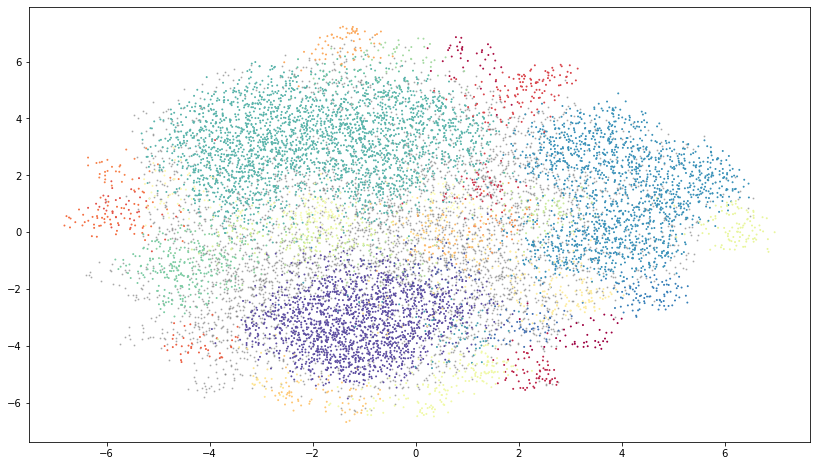

In [ ]:
clustering.plot_clusters(embeddings_minilm, clusters_minilm, n_neighbors=25, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_with_sw, clusters_minilm.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,3907,"[amp, tesla, erdayastronaut, spacex, yes, grea...","[577, 326, 177, 154, 143, 142, 135, 130, 120, ..."
1,0,40,"[id, aa, carmack, soumiksf, would, must, hope,...","[39, 39, 39, 4, 3, 2, 2, 2, 2, 2]"
2,1,39,"[roof, solar, tesla, solarglass, amp, glass, t...","[36, 28, 25, 9, 8, 6, 6, 5, 5, 4]"
3,2,65,"[nichegamer, justpaulinelol, flcnhvy, little, ...","[60, 4, 4, 3, 3, 3, 3, 3, 3, 3]"
4,3,53,"[engineers, feed, engineering, yes, haha, like...","[48, 47, 5, 4, 4, 4, 3, 3, 3, 3]"
5,4,127,"[tunnel, boring, tunnels, amp, la, boringcompa...","[58, 39, 37, 32, 21, 20, 20, 16, 15, 11]"
6,5,37,"[climate, change, global, warming, scientists,...","[26, 23, 7, 7, 6, 4, 3, 3, 3, 3]"
7,6,40,"[fredericlambert, electrekco, yeah, still, for...","[40, 10, 3, 3, 2, 2, 2, 2, 2, 2]"
8,7,63,"[amp, positive, c, false, test, covid, pcr, co...","[26, 22, 21, 19, 16, 16, 14, 13, 13, 12]"
9,8,32,"[ventilators, amp, tesla, hospitals, invasive,...","[26, 15, 12, 9, 7, 7, 6, 5, 5, 4]"


In [52]:
score_minilm

-0.14790907777648105

#### Distil-RoBERTa

In [53]:
clusters_distil, score_distil = clustering.generate_clusters(embeddings_distil,
                                                   n_neighbors=25,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=30,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 25
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 2
Label prop iterations: 2
Iterations: 5
17340,18441,9499,17,9331,110303


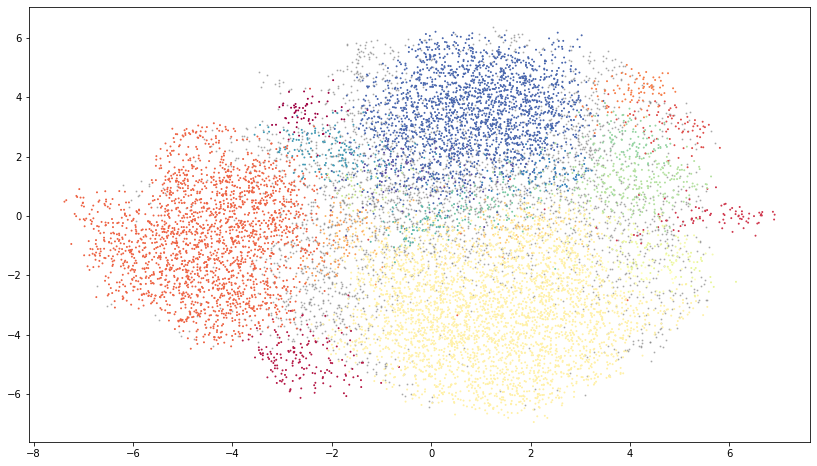

In [ ]:
clustering.plot_clusters(embeddings_distil, clusters_distil, n_neighbors=25, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_with_sw, clusters_distil.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,2993,"[amp, tesla, good, yes, like, great, flcnhvy, ...","[405, 198, 126, 119, 103, 96, 93, 88, 86, 80]"
1,0,65,"[erdayastronaut, tobyliiiiiiiiii, yes, sure, y...","[57, 12, 9, 8, 5, 4, 3, 3, 3, 2]"
2,1,164,"[tunnel, hyperloop, amp, tunnels, boring, bori...","[62, 38, 37, 35, 35, 19, 19, 19, 15, 14]"
3,2,87,"[amp, positive, c, symptoms, false, covid, tes...","[36, 21, 21, 19, 19, 18, 16, 14, 14, 14]"
4,3,76,"[ppathole, yes, amp, great, haha, flcnhvy, tru...","[72, 6, 5, 3, 3, 3, 3, 2, 2, 2]"
5,4,2125,"[spacex, amp, erdayastronaut, rocket, launch, ...","[582, 428, 402, 223, 186, 182, 180, 172, 154, ..."
6,5,89,"[cleantechnica, rationaletienne, true, interes...","[51, 28, 5, 4, 4, 3, 3, 3, 3, 3]"
7,6,72,"[engineers, feed, id, aa, carmack, like, yes, ...","[40, 39, 29, 29, 29, 6, 4, 3, 3, 3]"
8,7,32,"[la, texas, beautiful, south, amp, weather, to...","[5, 5, 4, 4, 3, 3, 3, 3, 2, 2]"
9,8,108,"[ai, openai, amp, flamethrower, open, flamethr...","[52, 20, 15, 15, 7, 7, 6, 6, 6, 5]"


In [54]:
score_distil

-0.5754001918447809

### Adding cluster labels to the dataframes

In [ ]:
df_without_sw['cluster_bow_default'] = clusters_bow.labels_.get()
df_without_sw['cluster_tfidf_default'] = clusters_tfidf.labels_.get()
df_without_sw['cluster_word2vec_default'] = clusters_wordvec.labels_.get()

In [ ]:
df_with_sw['cluster_use_default'] = clusters_use.labels_.get()
df_with_sw['cluster_mpnet_default'] = clusters_mpnet.labels_.get()
df_with_sw['cluster_minilm_default'] = clusters_minilm.labels_.get()
df_with_sw['cluster_distilbert_default'] = clusters_distil.labels_.get()

In [ ]:
#df_with_sw.to_csv('files/clusterized_tweets_with_stopwords.csv')
#df_without_sw.to_csv('files/clusterized_tweets_without_stopwords.csv')

### Hyperparameters tuning using Gaussian Optimization

In [13]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(2,100)),
    "n_components": hp.choice('n_components', range(2,100)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,200)),
    'min_samples': hp.choice('min_samples', range(2,200)),
    "random_state": 42
}

max_evals = 15

In [14]:
best_params_bow, best_clusters_bow, trials_bow = clustering.bayesian_search(embeddings_bow, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 16
Label prop iterations: 2
Iterations: 2
5362,61,522,10,89,364
  7%|▋         | 1/15 [00:04<01:01,  4.36s/trial, best loss: -0.0]Label prop iterations: 15
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
3331,67,404,9,117,433
 13%|█▎        | 2/15 [00:26<03:14, 14.93s/trial, best loss: -0.0]Label prop iterations: 16
Label prop iterations: 6
Label prop iterations: 2
Iterations: 3
3196,65,312,10,110,458
 20%|██        | 3/15 [00:53<04:05, 20.48s/trial, best loss: -0.0]Label prop iterations: 13
Label prop iterations: 3
Label prop iterations: 2
Iterations: 3
3238,68,390,9,113,378
 27%|██▋       | 4/15 [01:18<04:02, 22.08s/trial, best loss: -0.32639207592352226]Label prop iterations: 17
Label prop iterations: 4
Label prop iterations: 3
Iterations: 3
2642,73,304,13,120,471
 33%|███▎      | 5/15 [01:39<03:36, 21.70s/trial, best loss: -0.32639207592352226]Label prop iterations: 18
Label prop iterations

In [15]:
best_params_tfidf, best_clusters_tfidf, trials_tfidf = clustering.bayesian_search(embeddings_tfidf, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 17
Label prop iterations: 3
Iterations: 2
3550,54,290,9,82,679
  7%|▋         | 1/15 [00:15<03:42, 15.88s/trial, best loss: -0.06340026531365123]Label prop iterations: 23
Label prop iterations: 7
Label prop iterations: 3
Iterations: 3
3314,83,378,12,141,765
 13%|█▎        | 2/15 [00:21<02:05,  9.68s/trial, best loss: -0.06340026531365123]Label prop iterations: 15
Label prop iterations: 4
Iterations: 2
4156,51,386,8,77,362
 20%|██        | 3/15 [00:50<03:43, 18.67s/trial, best loss: -0.2212639684311565] Label prop iterations: 20
Label prop iterations: 8
Label prop iterations: 3
Iterations: 3
2169,71,246,11,116,601
 27%|██▋       | 4/15 [00:57<02:32, 13.85s/trial, best loss: -0.2212639684311565]Label prop iterations: 17
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 3
Iterations: 4
1458,87,162,13,157,963
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
1308,47,67,7,75,147

In [16]:
best_params_wordvec, best_clusters_wordvec, trials_wordvec = clustering.bayesian_search(embeddings_wordvec, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 20
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
3614,73,348,12,123,496
Label prop iterations: 2
Iterations: 1
1378,41,49,7,55,96
  7%|▋         | 1/15 [00:27<06:25, 27.52s/trial, best loss: -0.15159621773829784]Label prop iterations: 21
Label prop iterations: 4
Label prop iterations: 3
Iterations: 3
2207,70,261,10,116,551
Label prop iterations: 2
Iterations: 1
1349,33,45,5,42,70
 13%|█▎        | 2/15 [00:51<05:33, 25.68s/trial, best loss: -0.15159621773829784]Label prop iterations: 24
Label prop iterations: 4
Label prop iterations: 4
Iterations: 3
2818,75,261,11,122,568
Label prop iterations: 2
Iterations: 1
1350,35,45,5,42,69
 20%|██        | 3/15 [01:16<05:00, 25.01s/trial, best loss: -0.15159621773829784]Label prop iterations: 23
Label prop iterations: 4
Label prop iterations: 3
Iterations: 3
2513,67,282,10,120,529
Label prop iterations: 2
Iterations: 1
1380,34,46,6,47,83
 27%|██▋       |

In [17]:
best_params_use, best_clusters_use, trials_use = clustering.bayesian_search(embeddings_use, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 28
Label prop iterations: 3
Label prop iterations: 2
Label prop iterations: 2
Iterations: 4
3149,89,432,15,155,649
  7%|▋         | 1/15 [00:04<00:57,  4.13s/trial, best loss: -0.1728482837670149]Label prop iterations: 19
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
2300,79,325,11,145,575
 13%|█▎        | 2/15 [00:07<00:49,  3.82s/trial, best loss: -0.18331803710503466]Label prop iterations: 18
Label prop iterations: 3
Label prop iterations: 2
Iterations: 3
3374,64,400,10,113,438
 20%|██        | 3/15 [00:11<00:45,  3.78s/trial, best loss: -0.28948689380803194]Label prop iterations: 19
Label prop iterations: 10
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 2
Label prop iterations: 2
Iterations: 6
1567,105,208,15,203,770
Label prop iterations: 3
Iterations: 1
1346,34,45,5,39,82
 27%|██▋       | 4/15 [00:14<00:38,  3.50s/trial, best loss: -0.

In [18]:
best_params_mpnet, best_clusters_mpnet, trials_mpnet = clustering.bayesian_search(embeddings_mpnet, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 22
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 6
Label prop iterations: 2
Label prop iterations: 2
Iterations: 6
1639,114,213,17,212,819
Label prop iterations: 2
Iterations: 1
1341,35,47,5,49,72
  7%|▋         | 1/15 [00:03<00:51,  3.71s/trial, best loss: -0.26446156961816175]Label prop iterations: 22
Label prop iterations: 3
Label prop iterations: 4
Iterations: 3
3599,73,349,11,119,903
 13%|█▎        | 2/15 [00:07<00:51,  3.98s/trial, best loss: -0.34108348088020674]Label prop iterations: 19
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 3
Iterations: 4
2272,84,286,12,162,775
Label prop iterations: 2
Iterations: 1
2396,37,59,4,46,69
 20%|██        | 3/15 [00:34<02:53, 14.48s/trial, best loss: -0.42816539315485336]Label prop iterations: 20
Label prop iterations: 4
Label prop iterations: 3
Iterations: 3
2935,75,340,12,140,502
 27%|██▋       | 4/15 [00:39<01

In [19]:
best_params_minilm, best_clusters_minilm, trials_minilm = clustering.bayesian_search(embeddings_minilm, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 26
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 3
Iterations: 4
1849,83,195,12,151,698
Label prop iterations: 2
Iterations: 1
1304,33,45,5,39,66
  7%|▋         | 1/15 [00:03<00:46,  3.31s/trial, best loss: -0.2167806241205689]Label prop iterations: 19
Label prop iterations: 4
Label prop iterations: 3
Iterations: 3
3532,83,298,14,153,596
 13%|█▎        | 2/15 [00:07<00:52,  4.05s/trial, best loss: -0.3096686182948449]Label prop iterations: 20
Label prop iterations: 4
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
2343,85,330,13,155,561
 20%|██        | 3/15 [00:12<00:53,  4.43s/trial, best loss: -0.3105996115106402]Label prop iterations: 19
Label prop iterations: 4
Label prop iterations: 4
Label prop iterations: 2
Iterations: 4
2342,86,328,12,151,572
 27%|██▋       | 4/15 [00:16<00:47,  4.30s/trial, best loss: -0.3105996115106402]Label prop iterations: 19
Label prop 

In [20]:
best_params_distil, best_clusters_distil, trials_distil = clustering.bayesian_search(embeddings_distil, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 26
Label prop iterations: 8
Label prop iterations: 4
Label prop iterations: 2
Label prop iterations: 2
Iterations: 5
2313,102,183,16,181,772
  7%|▋         | 1/15 [00:03<00:47,  3.39s/trial, best loss: -0.22625840433866531]Label prop iterations: 22
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
2290,92,333,13,152,603
 13%|█▎        | 2/15 [00:07<00:46,  3.57s/trial, best loss: -0.2282518057494401] Label prop iterations: 18
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
3575,71,426,11,123,437
 20%|██        | 3/15 [00:11<00:44,  3.74s/trial, best loss: -0.2784195957927018]Label prop iterations: 21
Label prop iterations: 5
Label prop iterations: 3
Iterations: 3
2475,71,290,11,127,520
 27%|██▋       | 4/15 [00:16<00:48,  4.37s/trial, best loss: -0.2941209725752819]Label prop iterations: 20
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
35

In [21]:
columns = list(['name']) + list(best_params_distil.keys()) + list(trials_distil.best_trial['result'].keys())
bow_row = list(['BoW']) + list(best_params_bow.values()) + list(trials_bow.best_trial['result'].values())
tfidf_row = list(['TF-IDF']) + list(best_params_tfidf.values()) + list(trials_tfidf.best_trial['result'].values())
wordvec_row = list(['Word2Vec']) + list(best_params_wordvec.values()) + list(trials_wordvec.best_trial['result'].values())
use_row = list(['USE']) + list(best_params_use.values()) + list(trials_use.best_trial['result'].values())
mpnet_row = list(['MPNET']) + list(best_params_mpnet.values()) + list(trials_mpnet.best_trial['result'].values())
minilm_row = list(['MiniLM']) + list(best_params_minilm.values()) + list(trials_minilm.best_trial['result'].values())
distil_row = list(['Distil Roberta']) + list(best_params_distil.values()) + list(trials_distil.best_trial['result'].values())

rows = [bow_row, tfidf_row, wordvec_row, use_row, mpnet_row, minilm_row, distil_row]

df_compare = pd.DataFrame(rows, columns = columns)

### Evaluate and save

In [22]:
df_compare.head(10)

,name,min_cluster_size,min_samples,n_components,n_neighbors,random_state,loss,label_count,status
0,BoW,176,18,83,99,42,-0.585332,3,ok
1,TF-IDF,53,132,68,91,42,-0.261565,3,ok
2,Word2Vec,160,185,4,16,42,-0.521916,4,ok
3,USE,77,188,40,8,42,-0.289487,6,ok
4,MPNET,97,38,17,11,42,-0.428165,3,ok
5,MiniLM,4,176,82,23,42,-0.314549,6,ok
6,Distil Roberta,131,158,85,56,42,-0.313014,5,ok


In [25]:
#Bag of words
clustering.top_ten_words(tweets_without_sw, best_clusters_bow.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,1489,"[yes, welcome, yup, happy, youre, nice, amp, 1...","[91, 51, 41, 41, 40, 35, 33, 30, 22, 19]"
1,0,10048,"[amp, tesla, good, like, model, great, would, ...","[1862, 1033, 476, 402, 398, 385, 359, 357, 324..."
2,1,387,"[yes, amp, 1, lot, 7, 3, good, much, probably,...","[388, 13, 11, 9, 9, 7, 7, 6, 6, 6]"


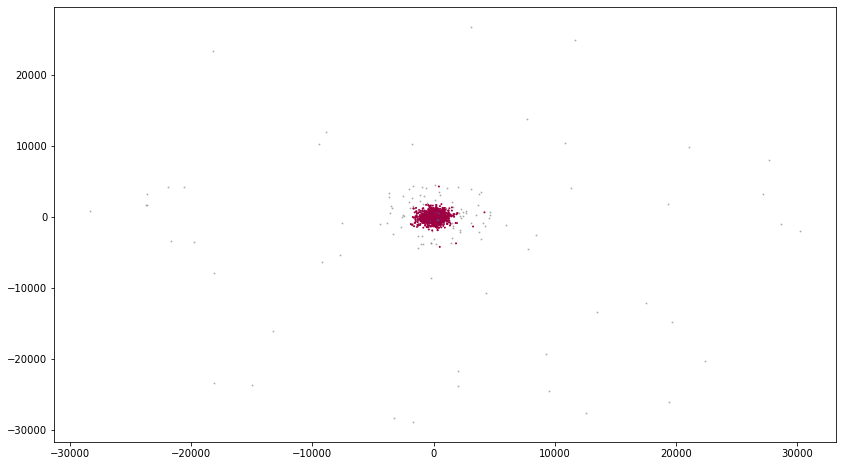

In [24]:
clustering.plot_clusters(embeddings_bow, best_clusters_bow, n_neighbors=50, min_dist=1.0)

In [26]:
#TF-IDF
clustering.top_ten_words(tweets_without_sw, best_clusters_tfidf.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,3424,"[amp, tesla, car, exactly, yes, would, 3, good...","[883, 385, 160, 151, 148, 141, 141, 134, 130, ..."
1,0,225,"[yes, 1, 8, 7, 2908, 5, um, 83, done, ultimately]","[224, 4, 4, 3, 2, 2, 2, 2, 2, 1]"
2,1,8275,"[amp, tesla, good, great, model, like, would, ...","[1025, 667, 354, 306, 280, 275, 240, 236, 226,..."


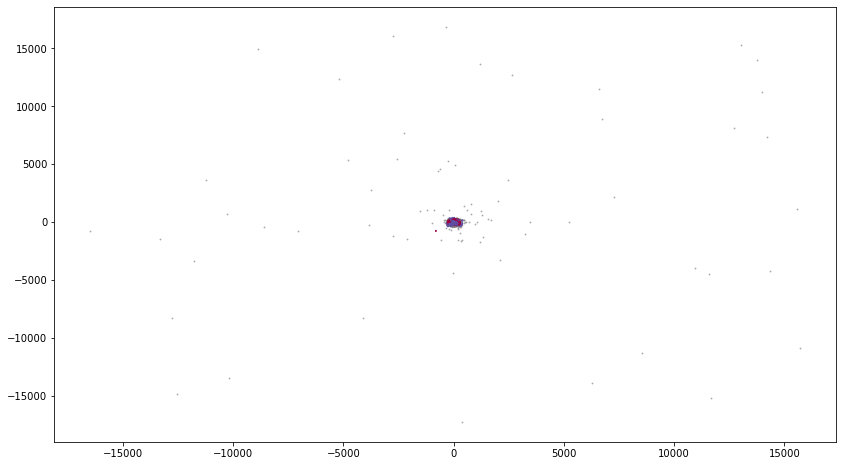

In [27]:
clustering.plot_clusters(embeddings_tfidf, best_clusters_tfidf, n_neighbors=50, min_dist=1.0)

In [28]:
#Word2vec
clustering.top_ten_words(tweets_without_sw, best_clusters_wordvec.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,636,"[exactly, sure, ok, true, haha, thanks, yes, y...","[76, 68, 52, 48, 44, 34, 32, 31, 29, 28]"
1,0,10862,"[amp, tesla, good, like, model, great, would, ...","[1908, 1053, 464, 405, 404, 390, 381, 378, 330..."
2,1,208,"[touché, yup, hg2g, samwise, former, naturally...","[3, 3, 2, 2, 2, 2, 2, 2, 2, 2]"
3,2,218,"[yes, 3201, 1stprinciples4l, 7xcp, 2serenity, ...","[218, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


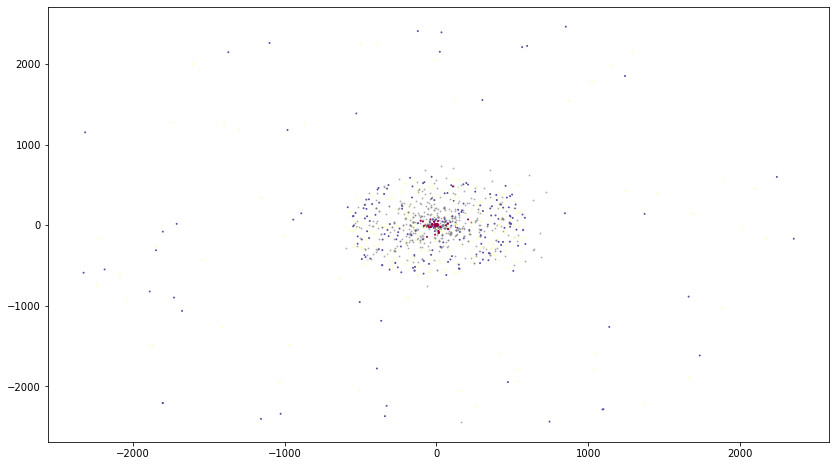

In [29]:
clustering.plot_clusters(embeddings_wordvec, best_clusters_wordvec, n_neighbors=50, min_dist=1.0)

In [30]:
#Universal sentence encoder
clustering.top_ten_words(tweets_with_sw, best_clusters_use.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,6458,"[amp, good, flcnhvy, great, tesla, yes, like, ...","[686, 239, 235, 206, 201, 196, 188, 187, 184, ..."
1,0,1908,"[spacex, amp, erdayastronaut, rocket, falcon, ...","[589, 466, 336, 227, 181, 176, 171, 126, 126, ..."
2,1,2550,"[tesla, amp, model, car, cars, production, goo...","[1617, 775, 277, 261, 186, 136, 121, 118, 116,..."
3,2,287,"[yes, yeah, yup, flcnhvy, teslaownerssv, erday...","[205, 32, 23, 17, 12, 11, 11, 8, 6, 5]"
4,3,759,"[would, flcnhvy, like, good, much, erdayastron...","[33, 31, 30, 30, 30, 28, 28, 26, 25, 25]"
5,4,251,"[rationaletienne, kristennetten, theonion, arc...","[8, 7, 7, 7, 6, 6, 6, 5, 4, 3]"


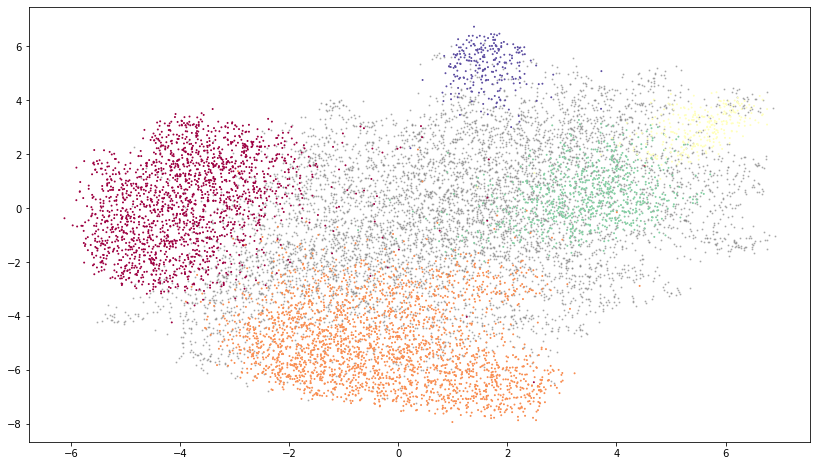

In [31]:
clustering.plot_clusters(embeddings_use, best_clusters_use, n_neighbors=50, min_dist=1.0)

In [32]:
#MPNET
clustering.top_ten_words(tweets_with_sw, best_clusters_mpnet.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,354,"[cleantechnica, id, aa, carmack, evafoxu, whol...","[73, 25, 25, 25, 25, 20, 18, 16, 16, 15]"
1,0,11666,"[amp, tesla, spacex, erdayastronaut, yes, mode...","[1844, 1788, 693, 598, 555, 468, 464, 422, 400..."
2,1,193,"[amp, c, justpaulinelol, ventilators, tesla, p...","[68, 29, 27, 27, 25, 25, 23, 20, 19, 19]"


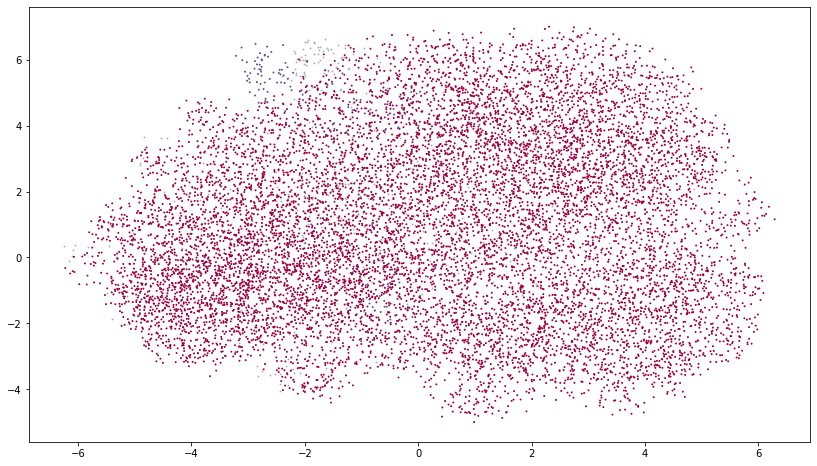

In [33]:
clustering.plot_clusters(embeddings_mpnet, best_clusters_mpnet, n_neighbors=50, min_dist=1.0)

In [34]:
#MiniLM
clustering.top_ten_words(tweets_with_sw, best_clusters_minilm.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,5858,"[amp, flcnhvy, tesla, yes, good, great, like, ...","[491, 243, 218, 215, 211, 204, 190, 178, 160, ..."
1,0,2922,"[tesla, amp, model, car, teslaownerssv, cars, ...","[1591, 959, 332, 291, 201, 196, 155, 142, 137,..."
2,1,2178,"[spacex, amp, erdayastronaut, rocket, falcon, ...","[566, 455, 379, 225, 180, 180, 177, 161, 135, ..."
3,2,112,"[amp, people, good, like, right, please, reali...","[14, 12, 8, 8, 7, 6, 6, 5, 5, 5]"
4,3,1124,"[yes, exactly, yeah, haha, good, sure, true, g...","[155, 38, 33, 29, 27, 27, 25, 24, 21, 19]"
5,4,19,"[hello, going, finally, come, tough, one, case...","[2, 2, 1, 1, 1, 1, 1, 1, 1, 1]"


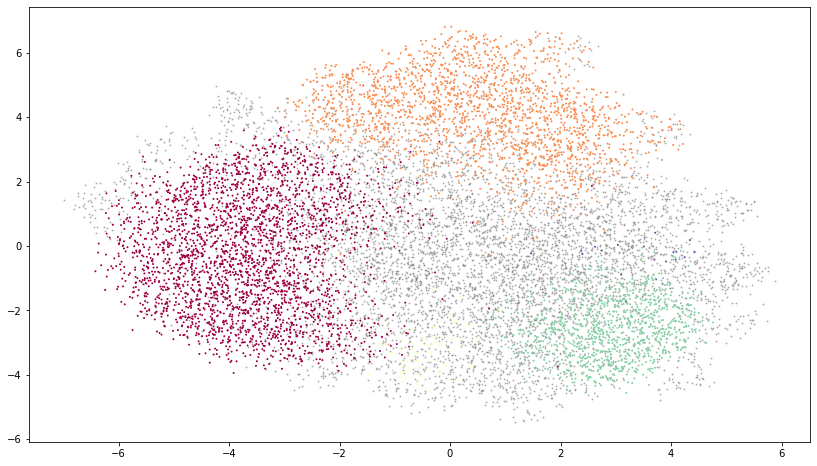

In [36]:
clustering.plot_clusters(embeddings_minilm, best_clusters_minilm, n_neighbors=50, min_dist=1.0)

In [37]:
#DistilRoBERTa 
clustering.top_ten_words(tweets_with_sw, best_clusters_distil.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,6315,"[amp, flcnhvy, good, tesla, great, like, yes, ...","[745, 268, 243, 229, 217, 215, 211, 178, 177, ..."
1,0,2587,"[tesla, amp, model, car, cars, autopilot, good...","[1578, 719, 360, 297, 190, 119, 119, 116, 111,..."
2,1,2048,"[spacex, amp, erdayastronaut, rocket, falcon, ...","[586, 433, 405, 228, 181, 179, 179, 171, 138, ..."
3,2,156,"[amp, media, public, true, please, article, ma...","[28, 26, 16, 14, 12, 11, 10, 9, 9, 9]"
4,3,1107,"[yes, haha, yeah, exactly, sure, ok, true, coo...","[186, 47, 37, 34, 33, 29, 28, 24, 22, 19]"


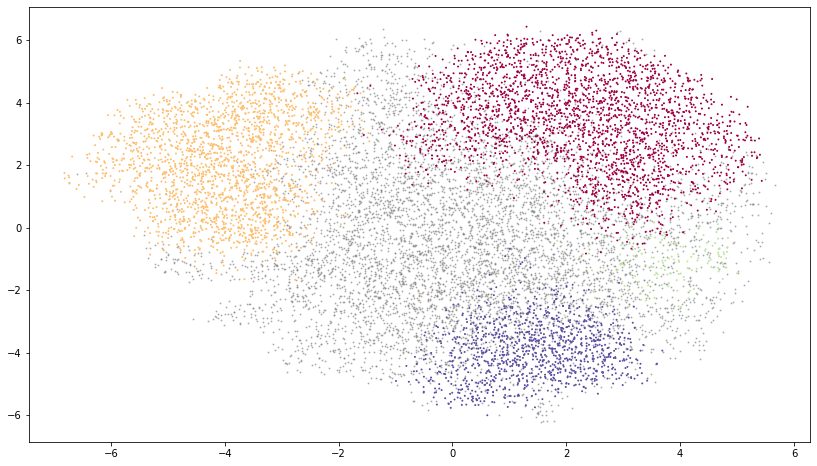

In [38]:
clustering.plot_clusters(embeddings_distil, best_clusters_distil, n_neighbors=50, min_dist=1.0)

In [ ]:
df_without_sw['cluster_bow_dbcv'] = best_clusters_bow.labels_.get()
df_without_sw['cluster_tfidf_dbcv'] = best_clusters_tfidf.labels_.get()
df_without_sw['cluster_word2vec_dbcv'] = best_clusters_wordvec.labels_.get()

In [ ]:
df_with_sw['cluster_use_dbcv'] = best_clusters_use.labels_.get()
df_with_sw['cluster_mpnet_dbcv'] = best_clusters_mpnet.labels_.get()
df_with_sw['cluster_minilm_dbcv'] = best_clusters_minilm.labels_.get()
df_with_sw['cluster_distilbert_dbcv'] = best_clusters_distil.labels_.get()

In [ ]:
df_with_sw.to_csv('files/clusterized_tweets_with_stopwords.csv', index = False)
df_without_sw.to_csv('files/clusterized_tweets_without_stopwords.csv', index = False)